# **<-------------------- Face Mask Detection -------------------->**

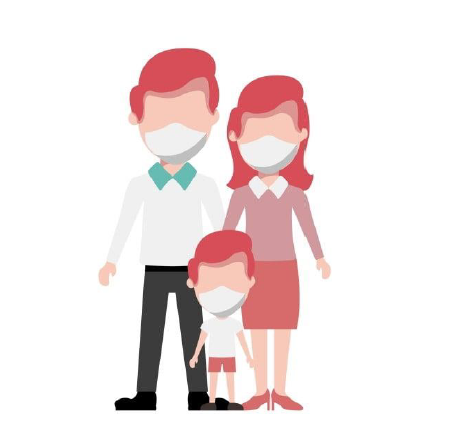

In [ ]:
#-> Importing_google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#-> Install the python version
!apt-get install python3.7

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.7 is already the newest version (3.7.13-1+bionic3).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
 #-> Importing required Libraries:::
import numpy as np                          #-> linear algebra

import pandas as pd                         #-> data processing, CSV file I/O (e.g. pd.read_csv)

#-> Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from sklearn.preprocessing import LabelBinarizer

import sys
import torch.optim as optim
import xmltodict
from tensorflow.keras.models import Model

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:
LearningRate = 1e-4
EPOCHS = 10
Batch_size = 512

In [ ]:
DIR='/content/drive/MyDrive/my kaggle/face-mask/dataset'
CATEGORIES=['/content/drive/MyDrive/my kaggle/face-mask/dataset/with_mask','/content/drive/MyDrive/my kaggle/face-mask/dataset/without_mask']

data =[]
labels = []

In [ ]:
from skimage.exposure import equalize_adapthist
from skimage.transform import resize
        
for category in CATEGORIES:
    path=os.path.join(DIR,category)
    for img in os.listdir(path):
        image=os.path.join(path,img)
        image =tf.keras.preprocessing.image.load_img(image,target_size=(96,96))
        image = tf.keras.preprocessing.image.img_to_array(image)
        image=tf.keras.applications.mobilenet_v2.preprocess_input(image)
        data.append(image)
        labels.append(category) 

In [ ]:
def display_20_image(images):
    
    w = 10
    h = 10
    fig = plt.figure(figsize=(9, 13))
    columns = 4
    rows = 5
    # prep (x,y) for extra plotting
    xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
    ys = np.abs(np.sin(xs))           # absolute of sine
    ax = []

    for i in range(columns*rows):
        img = np.random.randint(10, size=(h,w))
        ax.append( fig.add_subplot(rows, columns, i+1) )
        plt.imshow(images[i].reshape(96,96,3))

    # do extra plots on selected axes/subplots
    # note: index starts with 0
    ax[2].plot(xs, 3*ys)
    ax[19].plot(ys**2, xs)

    plt.show()  # finally, render the plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

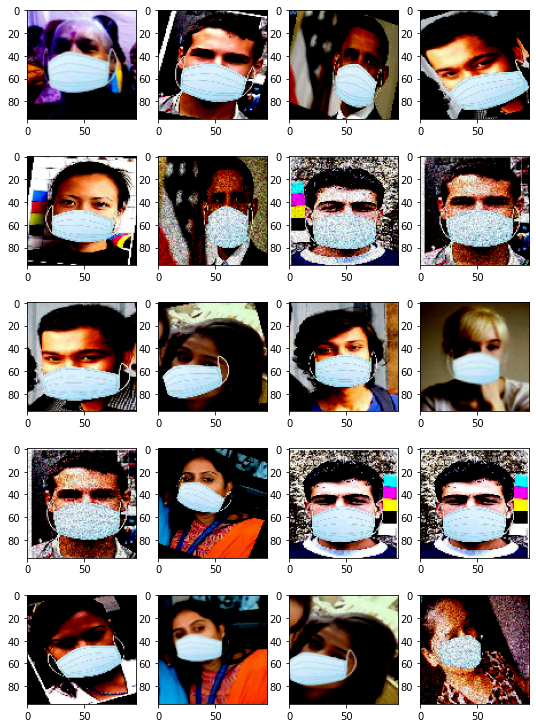

In [ ]:
display_20_image(data)

In [ ]:
encoder = LabelBinarizer()
labels=encoder.fit_transform(labels)

In [ ]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(data,labels,test_size=0.2,random_state=42,stratify=labels)
data=[]

In [ ]:
aug =tf.keras.preprocessing.image.ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False,
input_tensor=Input(shape=(96, 96, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=LearningRate, decay=LearningRate / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

model.summary()

[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 block_3_project (Conv2D)       (None, 12, 12, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 12, 12, 32)  128         ['block_3_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_4_expand (Conv2D)        (None, 12, 12, 192)  6144        ['block_3_project_BN[0][0]']     
                                                                                                  
 block_4_expand_BN (BatchNormal  (None, 12, 12, 192)  768        ['block_4_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_4_e

In [ ]:
# # train the head of the network
# print("[INFO] training head...")
# H = model.fit(
# aug.flow(X_train, y_train, batch_size=Batch_size),
# steps_per_epoch=len(X_train) // Batch_size,
# validation_data=(X_test, y_test),
# validation_steps=len(X_test) // Batch_size,
# epochs=EPOCHS)


# train the head of the network
print("[INFO] training head...")
H = model.fit(
X_train,y_train,
validation_freq=0.2,
epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
35/35 [==============================] - 10s 185ms/step - loss: 0.6096 - accuracy: 0.7555
Epoch 2/10
35/35 [==============================] - 6s 165ms/step - loss: 0.2143 - accuracy: 0.9118
Epoch 3/10
35/35 [==============================] - 6s 165ms/step - loss: 0.1502 - accuracy: 0.9436
Epoch 4/10
35/35 [==============================] - 6s 165ms/step - loss: 0.1215 - accuracy: 0.9536
Epoch 5/10
35/35 [==============================] - 6s 164ms/step - loss: 0.0936 - accuracy: 0.9673
Epoch 6/10
35/35 [==============================] - 6s 164ms/step - loss: 0.0940 - accuracy: 0.9664
Epoch 7/10
35/35 [==============================] - 6s 167ms/step - loss: 0.0774 - accuracy: 0.9673
Epoch 8/10
35/35 [==============================] - 6s 169ms/step - loss: 0.0663 - accuracy: 0.9782
Epoch 9/10
35/35 [==============================] - 6s 183ms/step - loss: 0.0594 - accuracy: 0.9782
Epoch 10/10
35/35 [==============================] - 6s 165ms/step - loss: 

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=Batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = predIdxs>0.5

# show a nicely formatted classification report
print(classification_report(y_test, predIdxs,
target_names=encoder.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.hdf5", save_format="hdf5")

[INFO] evaluating network...
                                                                 precision    recall  f1-score   support

   /content/drive/MyDrive/my kaggle/face-mask/dataset/with_mask       0.98      0.99      0.98       138
/content/drive/MyDrive/my kaggle/face-mask/dataset/without_mask       0.99      0.98      0.98       138

                                                       accuracy                           0.98       276
                                                      macro avg       0.98      0.98      0.98       276
                                                   weighted avg       0.98      0.98      0.98       276

[INFO] saving mask detector model...
